# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4    5         6  \
41001 201546 -0.093596 -0.261971 -0.583171  1.403605  0.017073  0.0 -0.467274   
      201547 -0.093596 -0.261971 -0.583171  1.403605  0.017073  0.0 -0.467274   
      201548 -0.093596 -0.261971 -0.583171  1.403605  0.017073  0.0 -0.467274   
      201549 -0.093596 -0.261971 -0.583171  1.403605  0.017073  0.0 -0.467274   
      201550 -0.093596 -0.261971 -0.583171  1.403605  0.017073  0.0 -0.467274   

                     7         8         9  ...      2039      2040      2041  \
41001 201546 -0.187198 -0.252905 -0.012345  ... -0.307946 -0.478249  0.478143   
      201547 -0.187198 -0.252905 -0.012345  ... -0.307946 -0.478249  0.478143   
      201548 -0.187198 -0.252905 -0.012345  ... -0.307946 -0.478249  0.478143   
      201549 -0.187198 -0.252905 -0.012345  ... -0.307946 -0.478249  0.478143   
      201550 -0.187198 -0.252905 -0.012345  ... -0.307946 -0.478249  0.478143   

                  2042      2043      2044      2045      2046      2047  \
41001 201546 -0.129449 -0.799987  1.342063 -0.117947 -0.738801 -0.372157   
      201547 -0.129449 -0.799987  1.342063 -0.117947 -0.738801 -0.372157   
      201548 -0.129449 -0.799987  1.342063 -0.117947 -0.738801 -0.372157   
      201549 -0.129449 -0.799987  1.342063 -0.117947 -0.738801 -0.372157   
      201550 -0.129449 -0.799987  1.342063 -0.117947 -0.738801 -0.372157   

                Labels  
41001 201546  0.064361  
      201547  0.091926  
      201548  0.082738  
      201549  0.082738  
      201550  0.211376  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4    5         6  \
41001 201820 -0.093596 -0.261971 -0.286259 -0.686333 -0.370933  0.0  0.615843   
      201821 -0.093596 -0.140211 -0.633835 -0.686333 -0.063401  0.0 -0.467274   
      201822  0.845009  0.053118 -0.632820 -0.650625 -0.370933  0.0  0.896847   
      201823 -0.093596  0.329706 -0.081740 -0.686333 -0.370933  0.0 -0.467274   
      201824 -0.093596 -0.261971 -0.696481 -0.686333 -0.370933  0.0 -0.184673   

                      7         8         9  ...      2039      2040  \
41001 201820  -0.187198 -0.252905  3.444024  ... -0.307946  1.024169   
      201821  11.330758 -0.252905  1.775366  ...  0.197326  3.122740   
      201822   3.935370  0.079460 -0.372576  ... -0.132997  1.862463   
      201823  -0.187198 -0.076728  1.109294  ... -0.307946 -0.711157   
      201824  -0.187198 -0.252905 -0.542592  ... -0.307946 -0.264231   

                  2041      2042      2043      2044      2045      2046  \
41001 201820 -0.410616 -0.129449 -0.567169 -0.621147 -0.117947 -0.788997   
      201821 -0.410616 -0.129449 -0.244304 -0.621147 -0.117947  0.616529   
      201822 -0.410616 -0.129449 -0.639248 -0.621147 -0.117947  0.790223   
      201823 -0.410616 -0.129449 -0.799987 -0.621147 -0.117947 -0.779601   
      201824 -0.410616 -0.129449 -0.468277 -0.621147 -0.117947  0.339994   

                  2047    Labels  
41001 201820  0.129631 -0.275610  
      201821 -0.284770 -0.321552  
      201822  0.812076 -0.238856  
      201823 -0.370623 -0.321552  
      201824 -0.372157 -0.293986  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

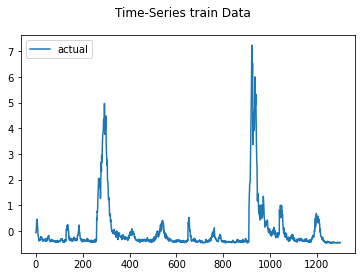

2023-03-15 17:19:27.295367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 17:19:27.295419: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 17:19:27.295443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-15 17:19:27.295632: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 17:19:27.475746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 113.829
Test RMSE: 680.124
Test sMAPE: 118.100
Test R Squared: -477.650
{'mae': 113.82855740930094, 'rmse': 680.1236816028799, 'smape': 118.09953746890601, 'r2': -477.64970519461514}


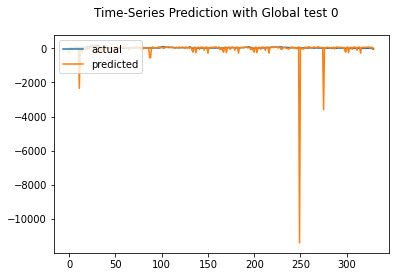

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 181.542
Test RMSE: 1241.977
Test sMAPE: 131.775
Test R Squared: -1595.133
{'mae': 181.5419154130148, 'rmse': 1241.9770459814501, 'smape': 131.77526845408937, 'r2': -1595.133233962667}


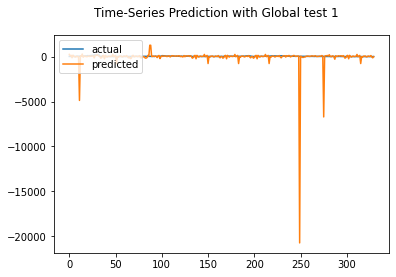

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 114.325
Test RMSE: 721.705
Test sMAPE: 132.851
Test R Squared: -537.966
{'mae': 114.32478979667931, 'rmse': 721.7046161169967, 'smape': 132.85082434159852, 'r2': -537.9655020582377}


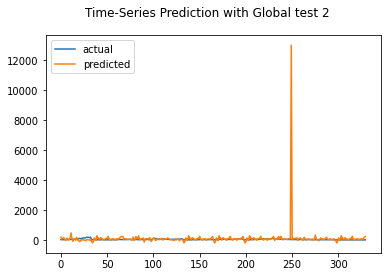

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 69.052
Test RMSE: 157.450
Test sMAPE: 115.234
Test R Squared: -24.652
{'mae': 69.0520202401461, 'rmse': 157.44979609339077, 'smape': 115.23442957669005, 'r2': -24.652293883636155}


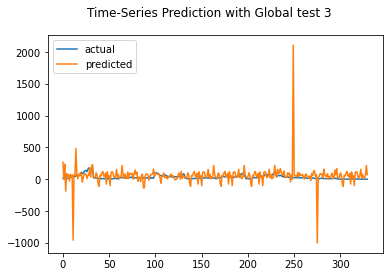

Test MAE: 77.496
Test RMSE: 232.767
Test sMAPE: 105.765
Test R Squared: -55.064
{'mae': 77.49582502516833, 'rmse': 232.7672091682092, 'smape': 105.76501318238884, 'r2': -55.06419629058562}


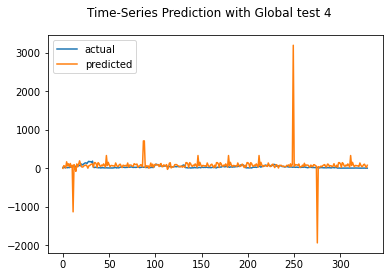

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 64.142
Test RMSE: 93.235
Test sMAPE: 125.812
Test R Squared: -7.995
{'mae': 64.1419122285012, 'rmse': 93.23544193574597, 'smape': 125.81153520158585, 'r2': -7.995060093693468}


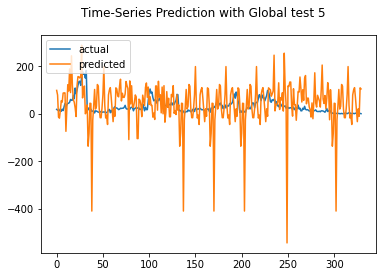

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 98.396
Test RMSE: 263.617
Test sMAPE: 127.931
Test R Squared: -70.910
{'mae': 98.39603460105982, 'rmse': 263.6173807055816, 'smape': 127.93072365908777, 'r2': -70.91013148124526}


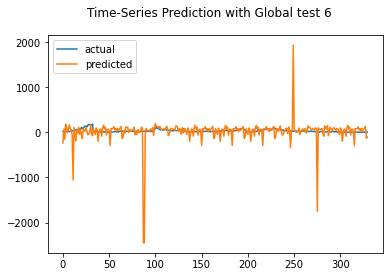

Test MAE: 49.060
Test RMSE: 140.245
Test sMAPE: 108.257
Test R Squared: -19.352
{'mae': 49.060226731408726, 'rmse': 140.24472368427857, 'smape': 108.25691373089748, 'r2': -19.35237349220182}


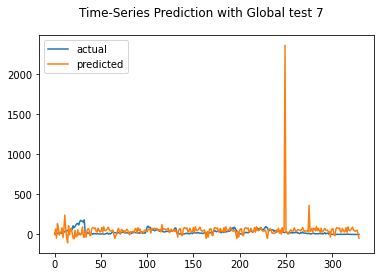

Test MAE: 88.984
Test RMSE: 578.260
Test sMAPE: 103.727
Test R Squared: -345.010
{'mae': 88.9836379056627, 'rmse': 578.2602712946085, 'smape': 103.72725673870723, 'r2': -345.01004974899604}


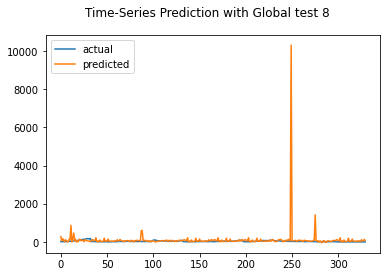

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 165.314
Test RMSE: 944.707
Test sMAPE: 128.525
Test R Squared: -922.498
{'mae': 165.31394323580193, 'rmse': 944.7065050417175, 'smape': 128.52540173234323, 'r2': -922.4976897005032}


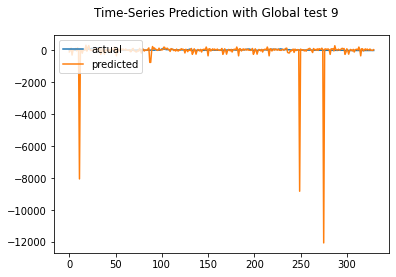

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 75.071
Test RMSE: 291.372
Test sMAPE: 123.630
Test R Squared: -86.849
{'mae': 75.07083813513093, 'rmse': 291.37181865454795, 'smape': 123.63042384485748, 'r2': -86.84905438611172}


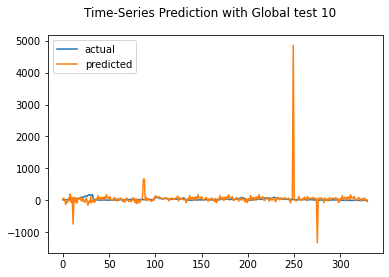

Test MAE: 138.520
Test RMSE: 1208.900
Test sMAPE: 110.983
Test R Squared: -1511.248
{'mae': 138.5202905008287, 'rmse': 1208.9004820928503, 'smape': 110.98260998584799, 'r2': -1511.2482938820249}


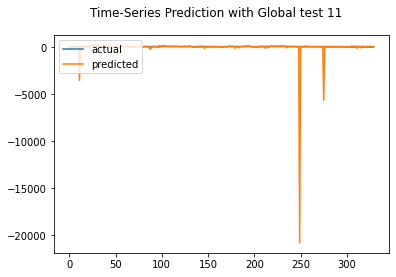

Test MAE: 64.898
Test RMSE: 287.572
Test sMAPE: 95.061
Test R Squared: -84.573
{'mae': 64.89767872948538, 'rmse': 287.5719717191157, 'smape': 95.06072370526377, 'r2': -84.57267573146008}


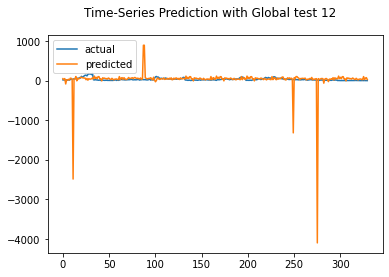

Test MAE: 88.708
Test RMSE: 629.522
Test sMAPE: 102.824
Test R Squared: -409.075
{'mae': 88.70777487357458, 'rmse': 629.5217772248375, 'smape': 102.82359866075988, 'r2': -409.07521230901176}


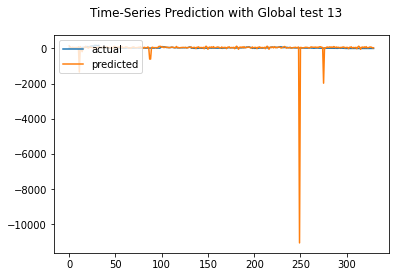

Test MAE: 83.371
Test RMSE: 466.099
Test sMAPE: 94.200
Test R Squared: -223.801
{'mae': 83.37148861848947, 'rmse': 466.0991970316439, 'smape': 94.19958791589379, 'r2': -223.80124450921045}


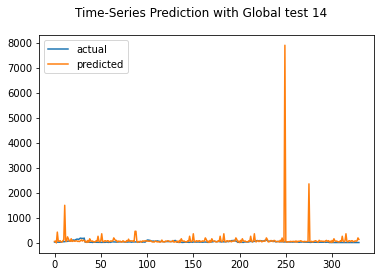

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 148.609
Test RMSE: 721.214
Test sMAPE: 123.681
Test R Squared: -537.233
{'mae': 148.60944386395542, 'rmse': 721.2140225828185, 'smape': 123.68109121382143, 'r2': -537.2330053706127}


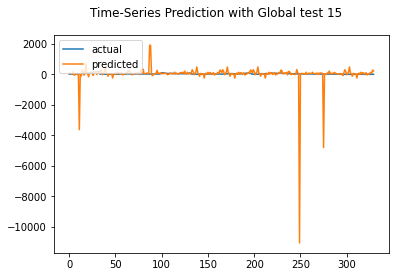

Test MAE: 68.253
Test RMSE: 315.816
Test sMAPE: 90.539
Test R Squared: -102.207
{'mae': 68.25341777079034, 'rmse': 315.8157388487897, 'smape': 90.53866706253042, 'r2': -102.20709183440293}


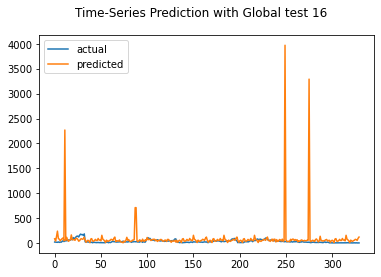

Test MAE: 110.281
Test RMSE: 1002.728
Test sMAPE: 100.235
Test R Squared: -1039.419
{'mae': 110.28052989388956, 'rmse': 1002.7278761444015, 'smape': 100.2348582132082, 'r2': -1039.41877072787}


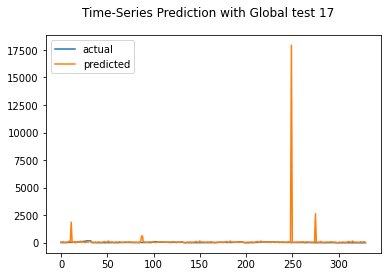

Test MAE: 64.513
Test RMSE: 271.000
Test sMAPE: 101.256
Test R Squared: -74.994
{'mae': 64.51274860880592, 'rmse': 270.999521789812, 'smape': 101.2564536755369, 'r2': -74.99395558364348}


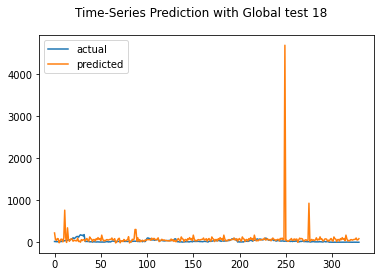

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 91.329
Test RMSE: 196.641
Test sMAPE: 131.605
Test R Squared: -39.012
{'mae': 91.32870731245387, 'rmse': 196.64104410811953, 'smape': 131.60493548273067, 'r2': -39.012007793236556}


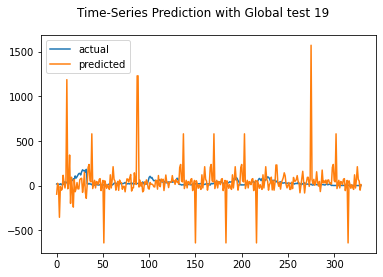

Test MAE: 69.882
Test RMSE: 295.089
Test sMAPE: 100.517
Test R Squared: -89.105
{'mae': 69.88232197653164, 'rmse': 295.0891651399371, 'smape': 100.51680953859474, 'r2': -89.10492490587005}


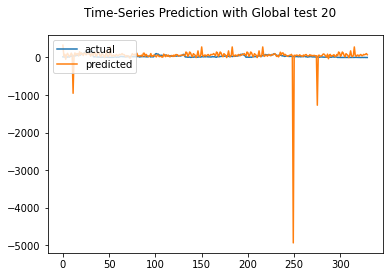

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 93.683
Test RMSE: 274.289
Test sMAPE: 134.793
Test R Squared: -76.850
{'mae': 93.68281984816898, 'rmse': 274.2892311528359, 'smape': 134.79283517541603, 'r2': -76.85016115830192}


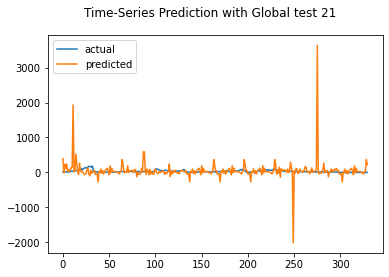

Test MAE: 110.194
Test RMSE: 651.649
Test sMAPE: 116.328
Test R Squared: -438.410
{'mae': 110.19357177579042, 'rmse': 651.6494282848929, 'smape': 116.3284044579145, 'r2': -438.41010373796996}


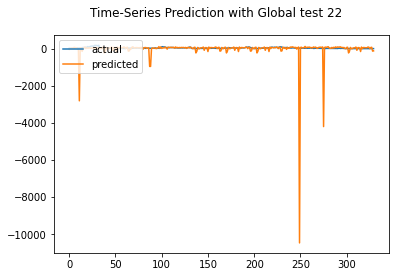

Test MAE: 70.501
Test RMSE: 529.764
Test sMAPE: 98.742
Test R Squared: -289.407
{'mae': 70.50113022512559, 'rmse': 529.7640244517195, 'smape': 98.74236646300479, 'r2': -289.40689733728397}


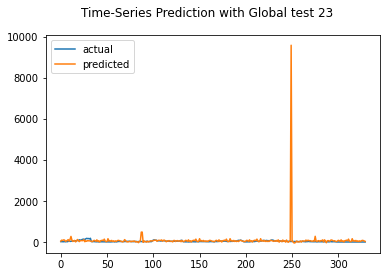

Test MAE: 84.452
Test RMSE: 417.251
Test sMAPE: 108.600
Test R Squared: -179.151
{'mae': 84.45245224327752, 'rmse': 417.25097708144074, 'smape': 108.59955181995898, 'r2': -179.15102039373824}


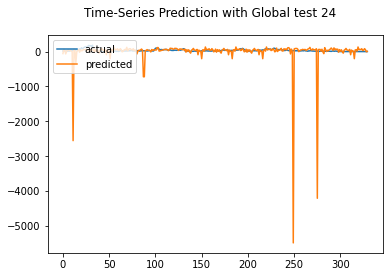

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 91.246
Test RMSE: 312.974
Test sMAPE: 116.327
Test R Squared: -100.358
{'mae': 91.24620207728762, 'rmse': 312.9743702251108, 'smape': 116.3272533725468, 'r2': -100.35835419373304}


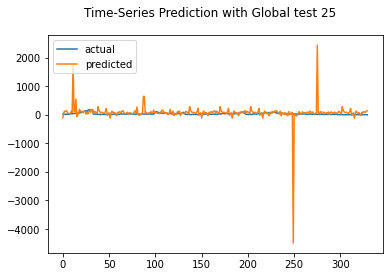

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 100.359
Test RMSE: 221.146
Test sMAPE: 131.033
Test R Squared: -49.606
{'mae': 100.35876505627776, 'rmse': 221.14602168494662, 'smape': 131.03349192191743, 'r2': -49.6057963787867}


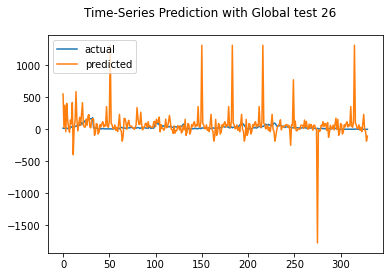

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 69.896
Test RMSE: 100.752
Test sMAPE: 117.446
Test R Squared: -9.504
{'mae': 69.89565534469756, 'rmse': 100.75154955642321, 'smape': 117.44648049588193, 'r2': -9.503776452483594}


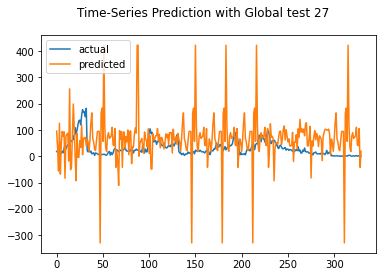

Test MAE: 88.788
Test RMSE: 723.419
Test sMAPE: 107.271
Test R Squared: -540.530
{'mae': 88.7882373043985, 'rmse': 723.4194855633374, 'smape': 107.27067520941276, 'r2': -540.5298574205788}


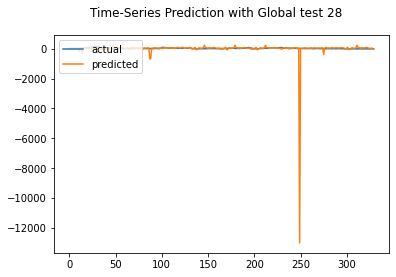

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 104.529
Test RMSE: 246.674
Test sMAPE: 132.633
Test R Squared: -61.964
{'mae': 104.52938354444323, 'rmse': 246.67441998632444, 'smape': 132.63286666768312, 'r2': -61.96369885229386}


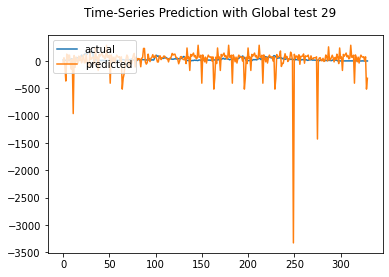

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 97.771
Test RMSE: 408.635
Test sMAPE: 116.134
Test R Squared: -171.788
{'mae': 97.77079783194895, 'rmse': 408.63478422068414, 'smape': 116.13445243778752, 'r2': -171.78763737164138}


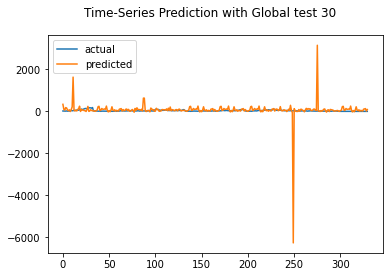

Test MAE: 74.795
Test RMSE: 361.965
Test sMAPE: 113.522
Test R Squared: -134.574
{'mae': 74.7948367339192, 'rmse': 361.9650471409408, 'smape': 113.52232737265172, 'r2': -134.57364489152843}


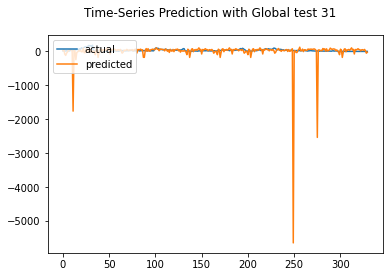

Test MAE: 85.809
Test RMSE: 571.813
Test sMAPE: 103.121
Test R Squared: -337.337
{'mae': 85.80896111726761, 'rmse': 571.8126169066974, 'smape': 103.12144697763803, 'r2': -337.33698050848676}


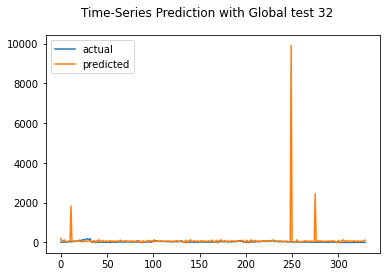

Test MAE: 45.886
Test RMSE: 118.048
Test sMAPE: 96.089
Test R Squared: -13.420
{'mae': 45.88557815407262, 'rmse': 118.04787422279905, 'smape': 96.08936173384632, 'r2': -13.419770331893265}


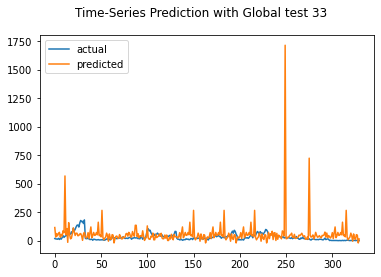

Test MAE: 77.794
Test RMSE: 585.430
Test sMAPE: 100.423
Test R Squared: -353.644
{'mae': 77.7938868728551, 'rmse': 585.430368457428, 'smape': 100.42337869394684, 'r2': -353.64390142716576}


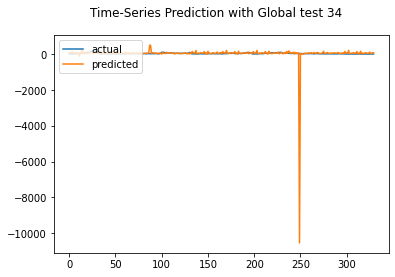

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 70.129
Test RMSE: 125.407
Test sMAPE: 120.289
Test R Squared: -15.274
{'mae': 70.12907504818656, 'rmse': 125.40721267747728, 'smape': 120.28919714258531, 'r2': -15.273727223081671}


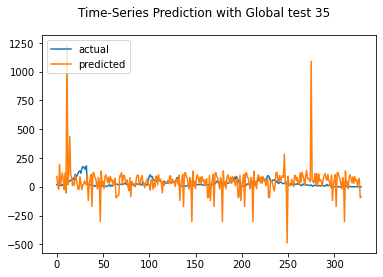

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 67.559
Test RMSE: 183.876
Test sMAPE: 117.046
Test R Squared: -33.986
{'mae': 67.55906016971126, 'rmse': 183.87579012279372, 'smape': 117.04554634375549, 'r2': -33.98574331866005}


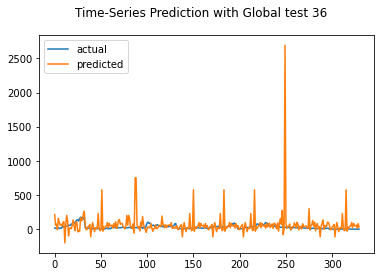

Test MAE: 64.393
Test RMSE: 282.681
Test sMAPE: 100.851
Test R Squared: -81.687
{'mae': 64.39342578712738, 'rmse': 282.68117992853524, 'smape': 100.85118523314587, 'r2': -81.6867252804147}


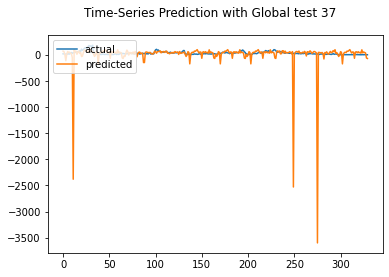

Test MAE: 47.328
Test RMSE: 145.453
Test sMAPE: 92.884
Test R Squared: -20.892
{'mae': 47.3276427099199, 'rmse': 145.45323253799967, 'smape': 92.88406407630514, 'r2': -20.892167205011294}


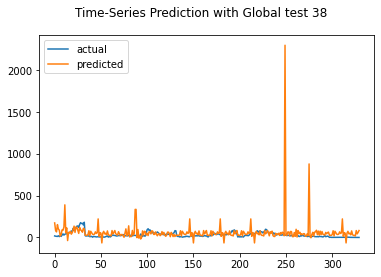

Test MAE: 82.723
Test RMSE: 728.838
Test sMAPE: 102.910
Test R Squared: -548.673
{'mae': 82.72276279420564, 'rmse': 728.8381678614365, 'smape': 102.91002772987682, 'r2': -548.6727623490128}


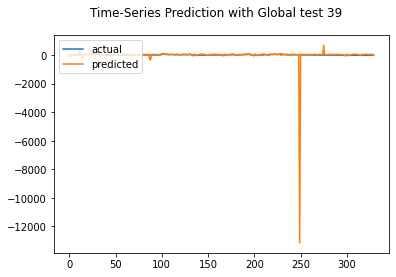

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 83.308
Test RMSE: 241.946
Test sMAPE: 123.926
Test R Squared: -59.573
{'mae': 83.30785379120798, 'rmse': 241.94607980798148, 'smape': 123.92645497131629, 'r2': -59.57301361698969}


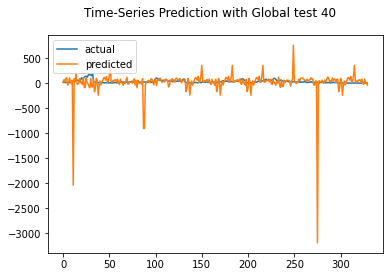

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 51.211
Test RMSE: 76.172
Test sMAPE: 110.019
Test R Squared: -5.004
{'mae': 51.21099071019527, 'rmse': 76.17225141931344, 'smape': 110.0194421680786, 'r2': -5.003929528874101}


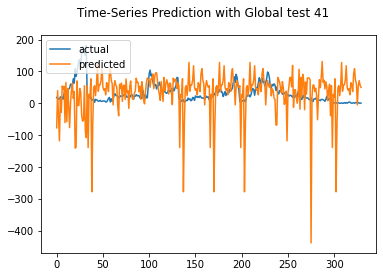

Test MAE: 81.799
Test RMSE: 458.895
Test sMAPE: 105.157
Test R Squared: -216.905
{'mae': 81.79864537251945, 'rmse': 458.89461853464576, 'smape': 105.15734279373666, 'r2': -216.90536906821256}


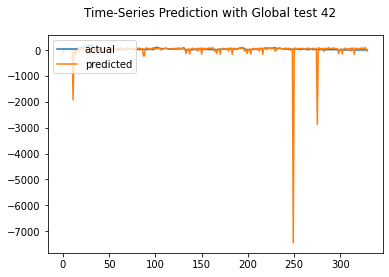

Test MAE: 99.848
Test RMSE: 560.971
Test sMAPE: 111.023
Test R Squared: -324.628
{'mae': 99.84791628018473, 'rmse': 560.9705769342177, 'smape': 111.02295151913863, 'r2': -324.62831928228474}


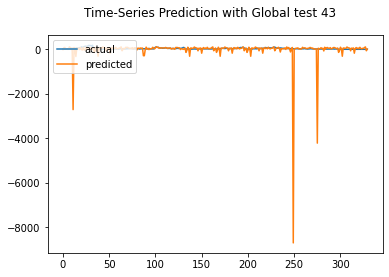

Test MAE: 90.968
Test RMSE: 812.161
Test sMAPE: 108.038
Test R Squared: -681.537
{'mae': 90.96842988801725, 'rmse': 812.1609394982888, 'smape': 108.03756366593161, 'r2': -681.5369989799941}


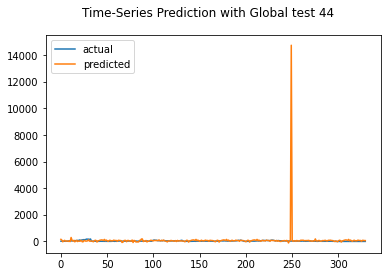

Test MAE: 110.257
Test RMSE: 1013.485
Test sMAPE: 103.151
Test R Squared: -1061.862
{'mae': 110.25689501107642, 'rmse': 1013.4853364009514, 'smape': 103.15079355313831, 'r2': -1061.8621479141023}


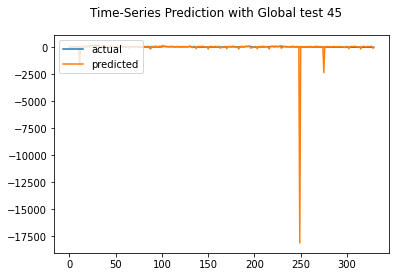

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 197.860
Test RMSE: 1096.160
Test sMAPE: 128.180
Test R Squared: -1242.341
{'mae': 197.8602126093525, 'rmse': 1096.1602604387833, 'smape': 128.1798888072134, 'r2': -1242.3405801511235}


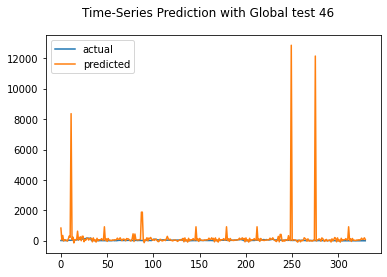

Test MAE: 106.203
Test RMSE: 813.340
Test sMAPE: 104.353
Test R Squared: -683.519
{'mae': 106.2031173287016, 'rmse': 813.3395661869674, 'smape': 104.3533428749175, 'r2': -683.5194633085334}


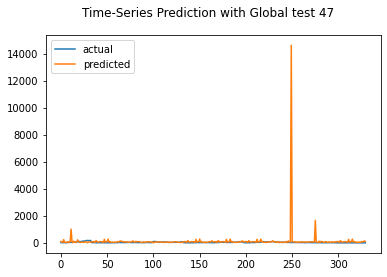

Test MAE: 97.982
Test RMSE: 742.001
Test sMAPE: 100.563
Test R Squared: -568.707
{'mae': 97.98162171732295, 'rmse': 742.0012785770708, 'smape': 100.5625001815377, 'r2': -568.7066763217225}


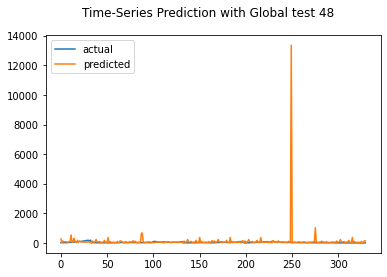

Test MAE: 119.650
Test RMSE: 688.466
Test sMAPE: 107.265
Test R Squared: -489.464
{'mae': 119.65023391138423, 'rmse': 688.4659287143865, 'smape': 107.26479882649906, 'r2': -489.46374121373293}


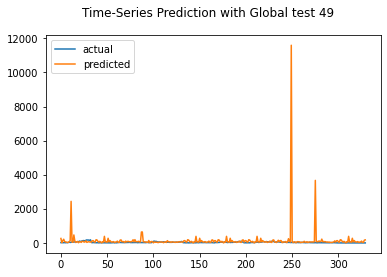

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 76.097
Test RMSE: 181.736
Test sMAPE: 117.916
Test R Squared: -33.176
{'mae': 76.09743048065539, 'rmse': 181.7357173892633, 'smape': 117.91554513504133, 'r2': -33.17610623480347}


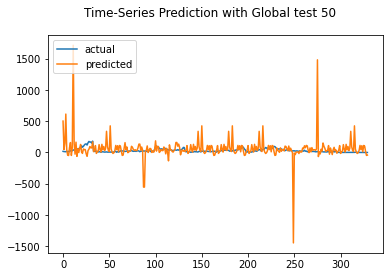

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 133.050
Test RMSE: 615.650
Test sMAPE: 132.681
Test R Squared: -391.202
{'mae': 133.04983300512487, 'rmse': 615.6503955958236, 'smape': 132.6814365826645, 'r2': -391.20247269029045}


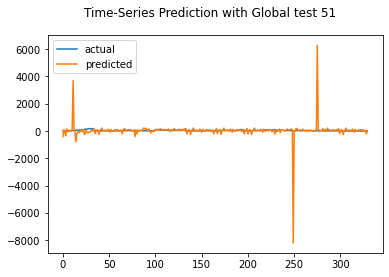

Test MAE: 84.895
Test RMSE: 725.901
Test sMAPE: 97.310
Test R Squared: -544.251
{'mae': 84.89506045923089, 'rmse': 725.900650271223, 'smape': 97.30999349364112, 'r2': -544.2508767224364}


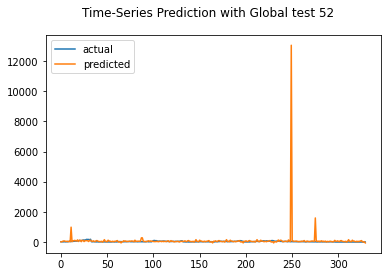

Test MAE: 71.169
Test RMSE: 328.941
Test sMAPE: 100.225
Test R Squared: -110.964
{'mae': 71.16880267750133, 'rmse': 328.9405349294903, 'smape': 100.22489671594616, 'r2': -110.9635835857059}


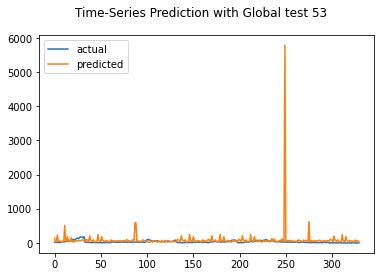

Test MAE: 54.821
Test RMSE: 172.847
Test sMAPE: 110.575
Test R Squared: -29.915
{'mae': 54.82147091143962, 'rmse': 172.84660252181973, 'smape': 110.57496331972477, 'r2': -29.914604625912542}


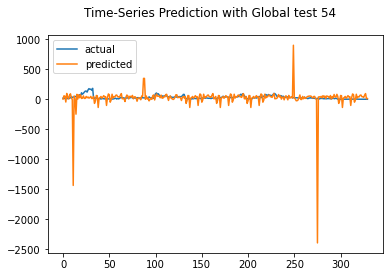

Test MAE: 104.041
Test RMSE: 1100.243
Test sMAPE: 97.621
Test R Squared: -1251.619
{'mae': 104.041154123346, 'rmse': 1100.242543404872, 'smape': 97.62141050870738, 'r2': -1251.6186384252665}


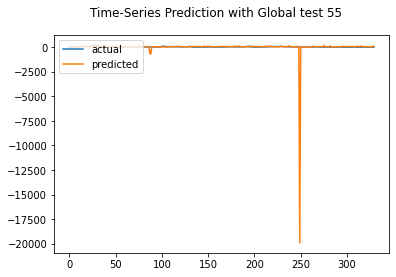

Test MAE: 54.096
Test RMSE: 192.067
Test sMAPE: 101.950
Test R Squared: -37.172
{'mae': 54.0958819503134, 'rmse': 192.06686055507248, 'smape': 101.95049222795366, 'r2': -37.172172430108475}


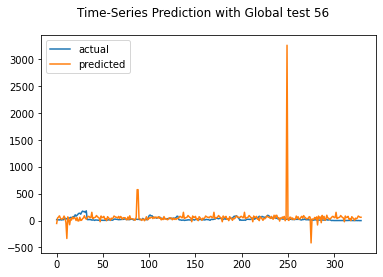

Test MAE: 135.771
Test RMSE: 1232.244
Test sMAPE: 102.659
Test R Squared: -1570.215
{'mae': 135.7707590106762, 'rmse': 1232.2441140557746, 'smape': 102.65862008003192, 'r2': -1570.2146015150613}


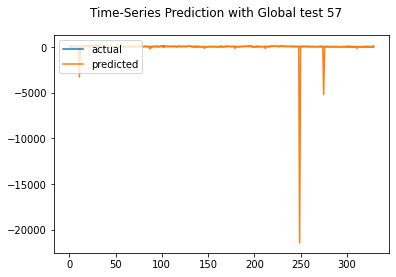

Test MAE: 92.263
Test RMSE: 658.463
Test sMAPE: 98.897
Test R Squared: -447.647
{'mae': 92.26269309448473, 'rmse': 658.463287880681, 'smape': 98.8971757446529, 'r2': -447.6473781209241}


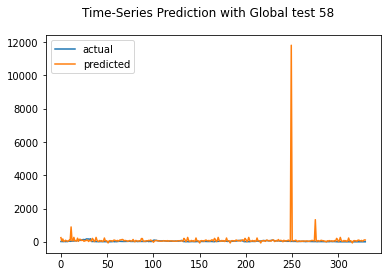

Test MAE: 90.933
Test RMSE: 680.959
Test sMAPE: 100.081
Test R Squared: -478.827
{'mae': 90.93337516206684, 'rmse': 680.9592468700828, 'smape': 100.08067054418262, 'r2': -478.8265168671702}


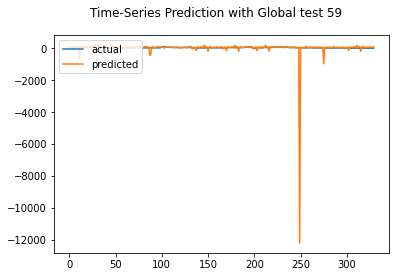

Test MAE: 66.197
Test RMSE: 443.303
Test sMAPE: 94.372
Test R Squared: -202.350
{'mae': 66.19739399389788, 'rmse': 443.30324849779674, 'smape': 94.37238467984324, 'r2': -202.34983729441294}


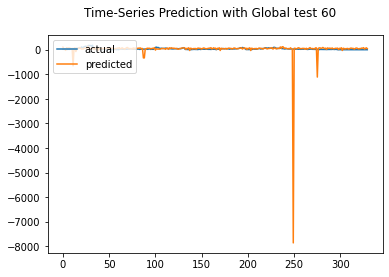

Test MAE: 73.337
Test RMSE: 414.296
Test sMAPE: 97.057
Test R Squared: -176.609
{'mae': 73.33719082203778, 'rmse': 414.2962919201486, 'smape': 97.0571950460707, 'r2': -176.6086422032075}


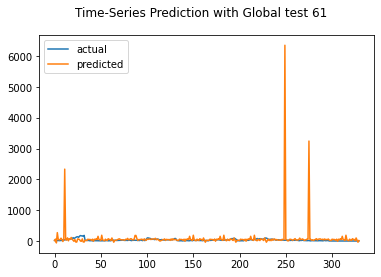

Test MAE: 92.531
Test RMSE: 1031.947
Test sMAPE: 102.756
Test R Squared: -1100.936
{'mae': 92.53123082604372, 'rmse': 1031.9466997914717, 'smape': 102.755639947564, 'r2': -1100.9364137064176}


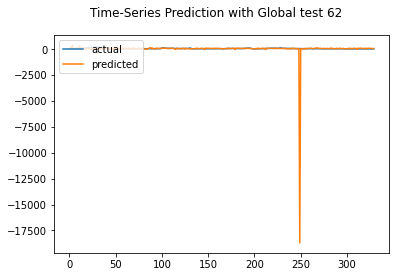

Test MAE: 41.297
Test RMSE: 83.214
Test sMAPE: 106.681
Test R Squared: -6.165
{'mae': 41.297391015968536, 'rmse': 83.21449615061209, 'smape': 106.68142518649701, 'r2': -6.16539238032468}


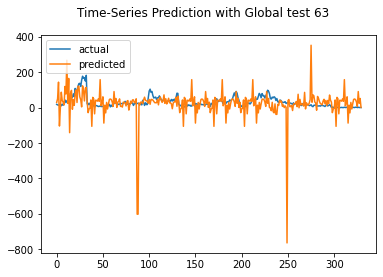

Test MAE: 144.819
Test RMSE: 1032.017
Test sMAPE: 97.751
Test R Squared: -1101.087
{'mae': 144.81931539882314, 'rmse': 1032.0169884912812, 'smape': 97.75105000721923, 'r2': -1101.0865305983036}


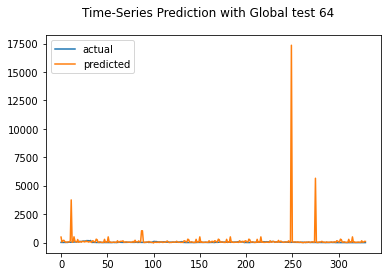

Test MAE: 116.743
Test RMSE: 837.939
Test sMAPE: 108.407
Test R Squared: -725.552
{'mae': 116.74277680281436, 'rmse': 837.9388900766685, 'smape': 108.40689058320056, 'r2': -725.5519890107308}


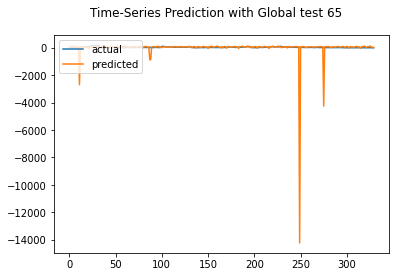

Test MAE: 107.610
Test RMSE: 808.202
Test sMAPE: 111.600
Test R Squared: -674.899
{'mae': 107.61047605023239, 'rmse': 808.2017770741263, 'smape': 111.60027595082748, 'r2': -674.8986884760961}


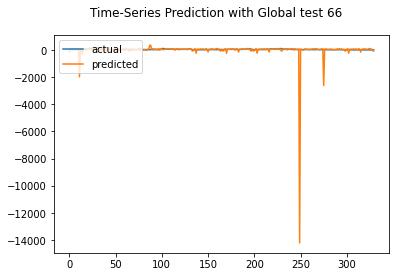

Test MAE: 58.632
Test RMSE: 131.053
Test sMAPE: 100.532
Test R Squared: -16.772
{'mae': 58.63164866644268, 'rmse': 131.05257589585608, 'smape': 100.53176706673372, 'r2': -16.771869883279575}


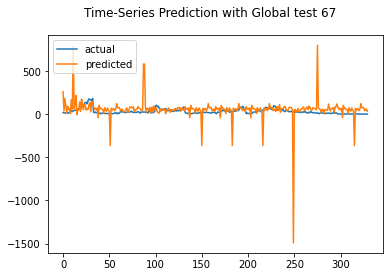

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 108.911
Test RMSE: 199.896
Test sMAPE: 139.642
Test R Squared: -40.348
{'mae': 108.91074125540979, 'rmse': 199.89638894182275, 'smape': 139.6417278440183, 'r2': -40.347751670181346}


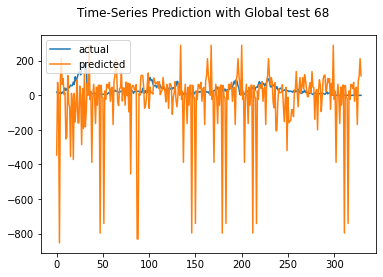

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 228.431
Test RMSE: 1677.436
Test sMAPE: 129.882
Test R Squared: -2910.614
{'mae': 228.4314048213489, 'rmse': 1677.435636559261, 'smape': 129.88174502376918, 'r2': -2910.613551895299}


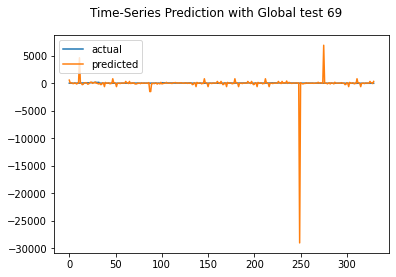

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 53.578
Test RMSE: 100.257
Test sMAPE: 114.113
Test R Squared: -9.401
{'mae': 53.577733007886195, 'rmse': 100.25725528885444, 'smape': 114.11264499008229, 'r2': -9.400964724878463}


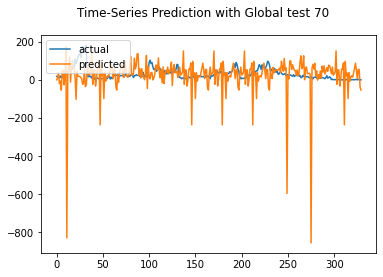

Test MAE: 68.364
Test RMSE: 437.963
Test sMAPE: 96.900
Test R Squared: -197.480
{'mae': 68.36369231939315, 'rmse': 437.96315417608463, 'smape': 96.90042280905443, 'r2': -197.4801828637819}


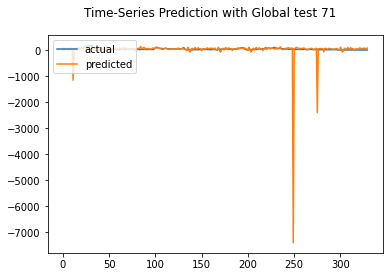

Test MAE: 131.733
Test RMSE: 1040.008
Test sMAPE: 100.764
Test R Squared: -1118.219
{'mae': 131.73298532926674, 'rmse': 1040.0076126203937, 'smape': 100.76367354087347, 'r2': -1118.2189071635878}


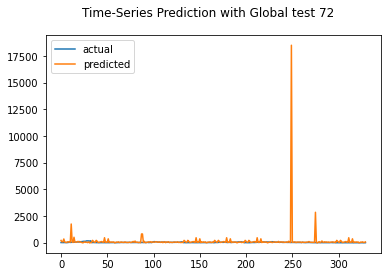

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 60.955
Test RMSE: 110.781
Test sMAPE: 112.775
Test R Squared: -11.699
{'mae': 60.955281343062715, 'rmse': 110.78125629018305, 'smape': 112.77466147376914, 'r2': -11.699147671003173}


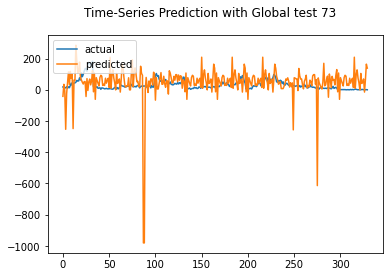

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 59.240
Test RMSE: 93.082
Test sMAPE: 113.987
Test R Squared: -7.966
{'mae': 59.23952587662321, 'rmse': 93.08249328623087, 'smape': 113.98698909232084, 'r2': -7.965572297853843}


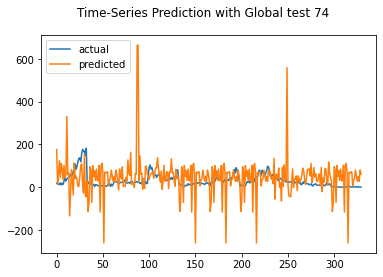

Test MAE: 92.370
Test RMSE: 461.645
Test sMAPE: 114.312
Test R Squared: -219.525
{'mae': 92.36952398536783, 'rmse': 461.6449108629944, 'smape': 114.31182502639594, 'r2': -219.52513989484171}


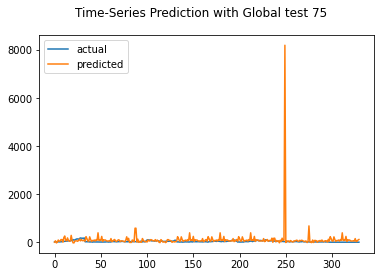

Test MAE: 140.895
Test RMSE: 1010.128
Test sMAPE: 95.459
Test R Squared: -1054.833
{'mae': 140.89507929484049, 'rmse': 1010.128313945397, 'smape': 95.45919825227094, 'r2': -1054.832657415303}


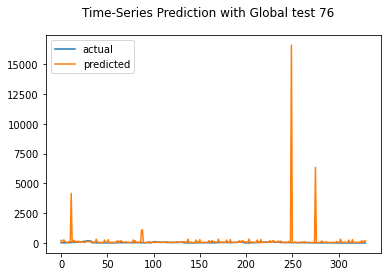

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 105.093
Test RMSE: 268.250
Test sMAPE: 125.814
Test R Squared: -73.460
{'mae': 105.0927696071791, 'rmse': 268.2500386520022, 'smape': 125.81377045076651, 'r2': -73.45975246227518}


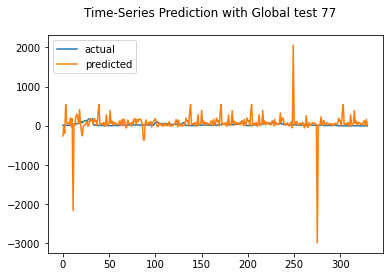

Test MAE: 80.379
Test RMSE: 258.713
Test sMAPE: 104.005
Test R Squared: -68.260
{'mae': 80.37893618869059, 'rmse': 258.7133694391286, 'smape': 104.00510702826529, 'r2': -68.25956284411573}


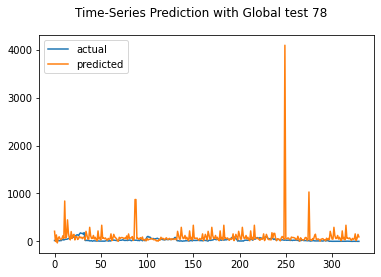

Test MAE: 83.959
Test RMSE: 529.379
Test sMAPE: 103.845
Test R Squared: -288.985
{'mae': 83.95861356728005, 'rmse': 529.3792852541225, 'smape': 103.84483535066146, 'r2': -288.9852365999862}


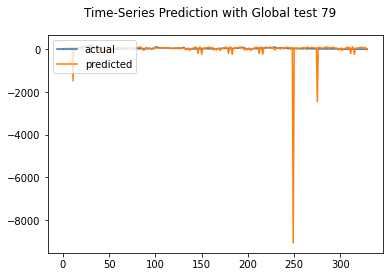

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 173.347
Test RMSE: 774.467
Test sMAPE: 139.174
Test R Squared: -619.651
{'mae': 173.3472888981754, 'rmse': 774.46673442482, 'smape': 139.17381862859858, 'r2': -619.6511126031805}


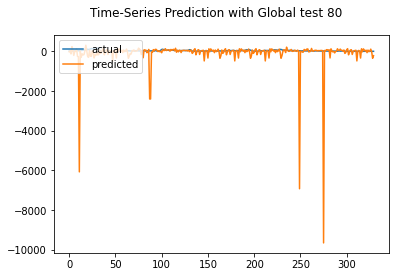

Test MAE: 214.019
Test RMSE: 2176.280
Test sMAPE: 118.357
Test R Squared: -4899.851
{'mae': 214.01938880921313, 'rmse': 2176.279960056553, 'smape': 118.35703049054916, 'r2': -4899.851323159911}


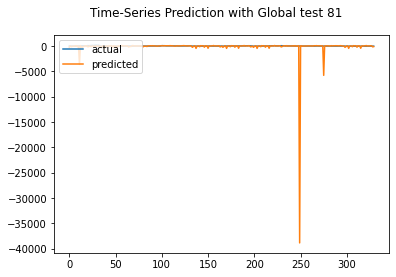

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 66.018
Test RMSE: 147.897
Test sMAPE: 114.866
Test R Squared: -21.634
{'mae': 66.01803886592388, 'rmse': 147.89705840596238, 'smape': 114.86552349141698, 'r2': -21.633987622505643}


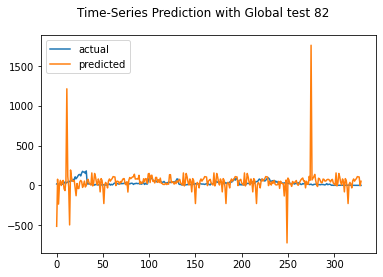

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 76.256
Test RMSE: 171.592
Test sMAPE: 121.904
Test R Squared: -29.467
{'mae': 76.25641124754242, 'rmse': 171.5917527543714, 'smape': 121.90434031180851, 'r2': -29.467359884491053}


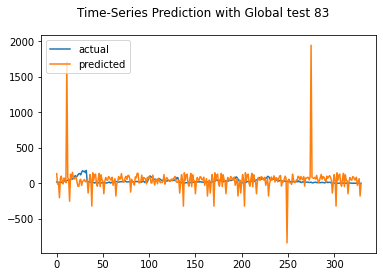

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 74.403
Test RMSE: 266.634
Test sMAPE: 117.083
Test R Squared: -72.565
{'mae': 74.40265239775181, 'rmse': 266.6341971961321, 'smape': 117.0829927993481, 'r2': -72.5654168052742}


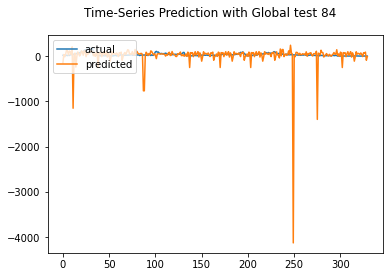

Test MAE: 77.259
Test RMSE: 487.439
Test sMAPE: 101.971
Test R Squared: -244.857
{'mae': 77.25883828816991, 'rmse': 487.4389604386165, 'smape': 101.97067120158644, 'r2': -244.85694423588907}


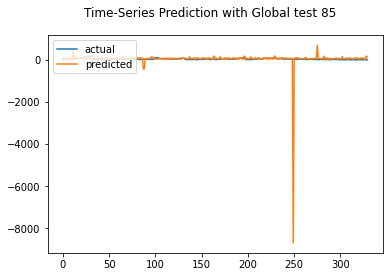

Test MAE: 77.097
Test RMSE: 410.200
Test sMAPE: 103.922
Test R Squared: -173.114
{'mae': 77.09683088822798, 'rmse': 410.19973367827913, 'smape': 103.92227174479902, 'r2': -173.11362190875496}


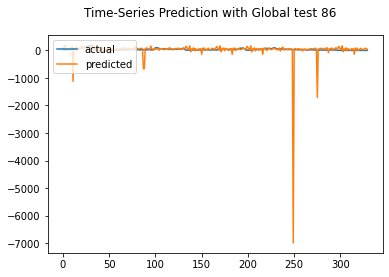

Test MAE: 63.322
Test RMSE: 437.979
Test sMAPE: 98.517
Test R Squared: -197.495
{'mae': 63.322007197322264, 'rmse': 437.9791304455122, 'smape': 98.51679420291498, 'r2': -197.49466367424972}


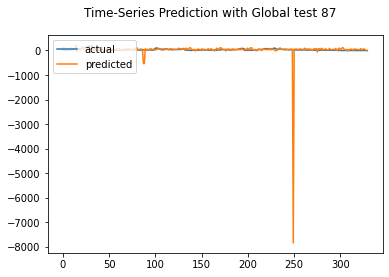

Test MAE: 77.386
Test RMSE: 437.147
Test sMAPE: 103.722
Test R Squared: -196.741
{'mae': 77.3862964630127, 'rmse': 437.147250121072, 'smape': 103.7222595708861, 'r2': -196.74135385229332}


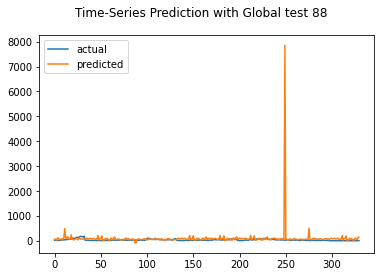

Test MAE: 66.705
Test RMSE: 336.786
Test sMAPE: 95.057
Test R Squared: -116.368
{'mae': 66.70518076203086, 'rmse': 336.78614852771113, 'smape': 95.05656887184368, 'r2': -116.36820006668397}


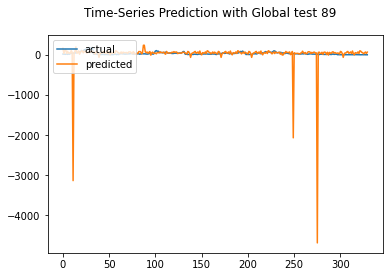

Test MAE: 76.102
Test RMSE: 436.827
Test sMAPE: 98.645
Test R Squared: -196.452
{'mae': 76.10179986086759, 'rmse': 436.8271111022677, 'smape': 98.64503384602283, 'r2': -196.45183336329282}


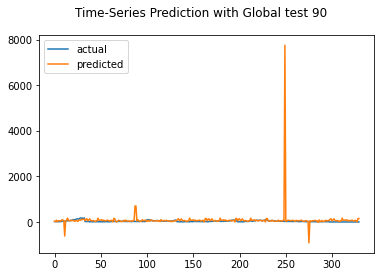

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 70.119
Test RMSE: 192.818
Test sMAPE: 104.906
Test R Squared: -37.471
{'mae': 70.11852815440207, 'rmse': 192.81783429284158, 'smape': 104.90576518506603, 'r2': -37.47125933106067}


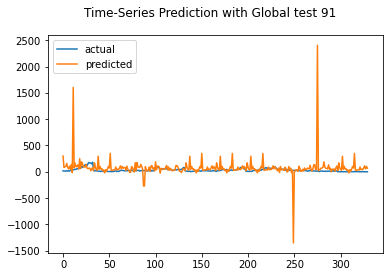

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 140.156
Test RMSE: 542.596
Test sMAPE: 129.946
Test R Squared: -303.646
{'mae': 140.15591388245423, 'rmse': 542.5960987534681, 'smape': 129.94588196366828, 'r2': -303.6458984265532}


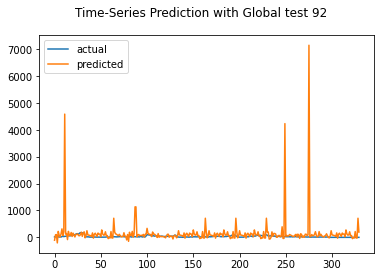

Test MAE: 43.625
Test RMSE: 104.306
Test sMAPE: 95.427
Test R Squared: -10.258
{'mae': 43.62453350916957, 'rmse': 104.30647465862238, 'smape': 95.42663950784238, 'r2': -10.25808534097871}


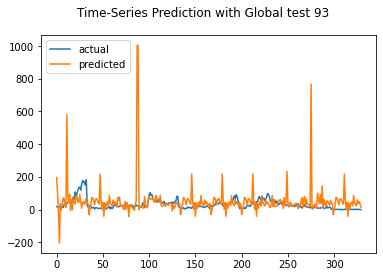

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 91.343
Test RMSE: 244.107
Test sMAPE: 125.301
Test R Squared: -60.660
{'mae': 91.34258127935004, 'rmse': 244.10738308301447, 'smape': 125.30074005786962, 'r2': -60.66004417980796}


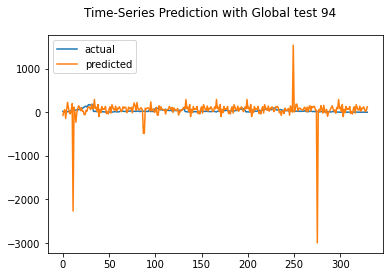

Test MAE: 179.448
Test RMSE: 1789.195
Test sMAPE: 112.020
Test R Squared: -3311.512
{'mae': 179.44837411894943, 'rmse': 1789.1951362726634, 'smape': 112.01990290271206, 'r2': -3311.5116893461836}


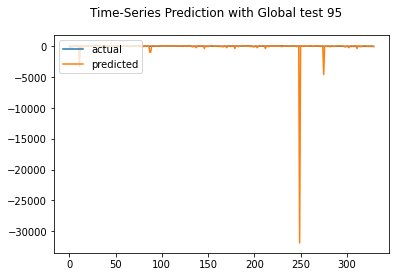

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 199.194
Test RMSE: 1086.977
Test sMAPE: 130.888
Test R Squared: -1221.595
{'mae': 199.19393170755922, 'rmse': 1086.9767570972174, 'smape': 130.88757998450816, 'r2': -1221.594722975873}


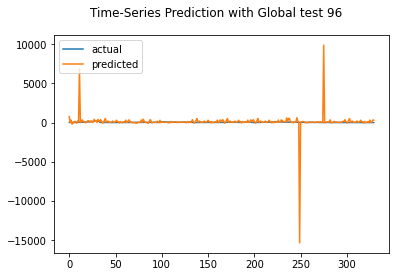

Test MAE: 70.695
Test RMSE: 280.329
Test sMAPE: 104.011
Test R Squared: -80.316
{'mae': 70.6952652587132, 'rmse': 280.32893068164844, 'smape': 104.01123651092517, 'r2': -80.31634363276709}


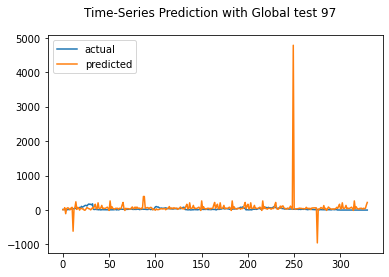

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 96.509
Test RMSE: 289.095
Test sMAPE: 115.547
Test R Squared: -85.481
{'mae': 96.509313933461, 'rmse': 289.0947020039946, 'smape': 115.54734128561164, 'r2': -85.48131152475105}


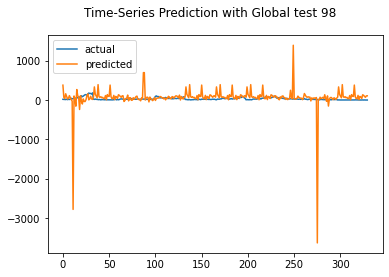

Test MAE: 97.800
Test RMSE: 737.641
Test sMAPE: 105.151
Test R Squared: -562.031
{'mae': 97.80027891650344, 'rmse': 737.6413737350634, 'smape': 105.1513238110078, 'r2': -562.0312984601571}


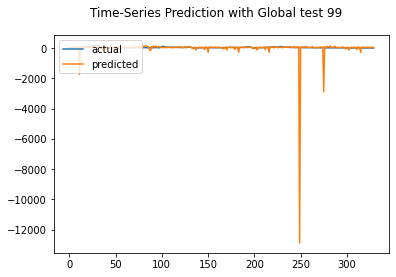

rmse : average=524.426, std=393.558
mae : average=94.355, std=37.594
smape : average=110.676, std=12.204
r2 : average=-443.857, std=712.170


([524.4257526995655, 393.55815831982113],
 [94.35507889615572, 37.59408880447552],
 [110.67608806143856, 12.203869906574777],
 [-443.85650650825687, 712.1697293072377])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')